In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [230]:
def quantize(x, s):
    return int(np.clip(np.round(s*x), -128, 127))

def sigmoid(x): 
    return 1 / (1 + math.exp(-x))

# https://sci-hub.se/10.1109/ICENCO48310.2019.9027479
def zaki_sig_default(x):
    if x >= 0:
        return (math.log2((2 * x) + 0.486) / 8) + 0.63
    else:
        return (-math.log2((-x * 0.5) + 0.008458) / 16) + 0.07

def zaki_sigq(x, s):
    x = quantize(x, s)
    if x >= 0:
        return (quantize(math.log2((x << 1) + 127), s) >> 3) + quantize(0.63, 409.30)
    else:
        return -(quantize(math.log2(-(x >> 1) + 3), s) >> 4) + quantize(0.07, 409.30)

In [231]:
val = -12.121
print(sigmoid(val))
print(zaki_sig_default(val))

5.443951163233243e-06
-0.09259055228337995


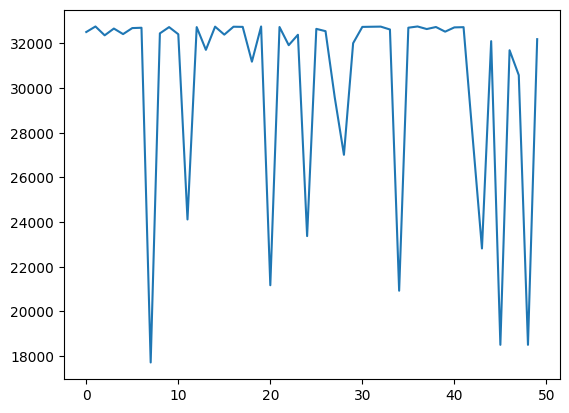

In [4]:
arr = 5 * np.random.random_sample((150,))
x = [i for i in range(-10, 11)]
ys = []
ys.append(("logistic", [32510,32758,32362,32665,32417,32686,32701,17715,32449,32730,32411,24118,32730,31712,32750,32393,32747,32740,31182,32757,21173,32734,31921,32387,23373,32651,32548,29586,27013,32010,32739,32746,32752,32623,20928,32703,32758,32643,32734,32526,32717,32727,27745,22819,32101,18505,31695,30579,18505,32190]))
#ys.append(("default",  [100 * sigmoid(i) for i in x]))
#ys.append(("zaki", [zaki_sig_default(i) for i in x]))
#ys.append(("zaki_q", [zaki_sigq(i, 409.30) for i in x]))
for (name, li) in ys:
    plt.plot(li, label=name)

In [5]:
array = [0.486, 0.00848, 0.63, 0.007]
s = 255 / (np.max(array) - np.min(array))

In [442]:
def normal_get(b, indices):
    return b[indices]

## Return strides array given shape 
def get_stride_vec(shape):
    li = []
    for i in range(len(shape)):
        product = np.prod(shape[i+1:])
        li.append(product)
    return np.array(li).astype(np.int32)

## auxillary
def get_with_stride(b, indices, strides):
    stride = np.sum(strides * indices)
    print(f"index: {stride}")
    print(f"value: {b.flatten()[stride]}")
    return b.flatten()[stride]
    
def xget(b, indices):
    strides = get_stride_vec(b.shape)
    return get_with_stride(b, indices, strides)

## Permute array by perm
def perm(array, perm):
    return np.array(array)[perm]

def xtranspose(arr, p):
    size = np.prod(arr.shape)
    barr = np.zeros(size)
    astride = get_stride_vec(arr.shape)
    bstride = get_stride_vec(perm(arr.shape, p))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                index = np.sum(bstride * perm([i,j,k],p))
                barr[index] = arr[i,j,k]
    return barr.astype(np.int32)

def get_concated_shape(a, b, axis):
    li = []
    for index, (i, j) in enumerate(zip(a.shape,a.shape)):
        if index == axis:
            li.append(i+j)
        else:
            li.append(i)
    return li

def get_concat_offset(shape, axis):
    return np.prod(shape[axis:])
    
def xconcat(a, b, axis):
    post_concat_shape = get_concated_shape(a, b, axis)
    post_concat_stride = get_stride_vec(post_concat_shape)
    barr = np.zeros(np.prod(post_concat_shape))
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            for k in range(a.shape[2]):
                index = np.sum(post_concat_stride * [i,j,k])
                barr[index] = a[i,j,k]
    cnt = 0
    for i in range(b.shape[0]):
        for j in range(b.shape[1]):
            for k in range(b.shape[2]):
                cnt = cnt + 1
                offset = get_concat_offset(b.shape, axis)
                index = np.sum(post_concat_stride * [i,j,k]) + offset
                barr[index] = b[i,j,k]
    return barr

In [443]:
b = np.arange(84).reshape(4,3,7)
p = [1,0,2]
bt = np.transpose(b, p)
index = [1,2,1]
print(f"b stride: {get_stride_vec(b.shape)}, b shape: {b.shape}")
print(f"bt stride: {get_stride_vec(bt.shape)}, bt shape: {bt.shape}")
get_with_stride(b, get_stride_vec(b.shape), index)
get_with_stride(bt, get_stride_vec(bt.shape), perm(index, p))

b stride: [21  7  1], b shape: (4, 3, 7)
bt stride: [28  7  1], bt shape: (3, 4, 7)
index: 36
value: 36
index: 64
value: 36


36

In [444]:
arr = np.arange(84).reshape(4,3,7)
index = [1,0,2]
xtranspose(arr, index) == np.transpose(arr, index).flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [445]:
## CONCAT

In [446]:
barr = xconcat(a, a, 1)
barr == np.concatenate((a, a), axis=1).flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [450]:
a = np.arange(84).reshape(4,3,7)
b = np.ones(84).reshape(4,3,7)
print(a.flatten())
print(np.concatenate((a,b), axis=0).flatten())
print(np.transpose(np.concatenate((a,b), axis=0), [2,0,1]).flatten())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]
[ 0.  7. 14. 21. 28. 35. 42. 49. 56. 63. 70. 77.  1.  1.  1.

In [ ]:
for i,v in enumerate(np.concatenate((a,b), axis=2).flatten()):
    print(i,v)
    #if v != 1.0 and v % 7.0 == 0:
    #    print(i,v)